# Introduction

Recommender systems are all around us. They are in our streaming platforms from which we entertain ourselves with music, video content and music. They are also in eCommerce websites like Amazon, coolblue and bol, where in we get recommended products in our mail, similar to previous purchases.

In this tutorial we are going to learn how to build a simple recommender system with Tensorflow

## Workflow

The workflow will take the following steps:
1. Reading and Understanding the data
2. Processing the Data and preparing it for model building
3. Fitting the model
4. Evaluating its performance (How well has the model learnt?)
5. A quick demonstration with the model


In [2]:
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from IPython.display import Markdown, display

stop_words = stopwords.words('english')

## 1. Reading and Understanding the Data

After reading the data, we will like to know the following:

1. How many users are in the data?
2. How many movies are represented in the data
3. How many possible ratings are there?
4. What is the distribution of ratings
5. Picking just a few sample of users, perhaps 20 or 30, is there any genre of movies they rate highly or lowly?

In [4]:
RATINGS_PATH = "data/ratings.csv" 
MOVIES_PATH = "data/movies.csv"

ratings_df = pd.read_csv(RATINGS_PATH)
movies_df = pd.read_csv(MOVIES_PATH)

In [5]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
movies_df.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [7]:
movies_df.shape

(9742, 3)

In [48]:
movies_df['movieId'].nunique()

9742

In [8]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [9]:
ratings_df.shape

(100836, 4)

In [10]:
ratings_df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

### 1.1. How many users are in the data?

In [14]:
ratings_df.userId.nunique()

610

In [103]:
ratings_df['userId'].max()

610

### 1.2. How many movies are represented in the data

In [15]:
ratings_df.movieId.nunique()

9724

### 1.3. How many possible ratings are there?

In [16]:
ratings_df.rating.nunique()

10

### 1.4. What is the distribution of ratings

In [18]:
ratings_df['rating'].max(), ratings_df['rating'].min()

(5.0, 0.5)

#### Distribution of Ratings in the Dataset

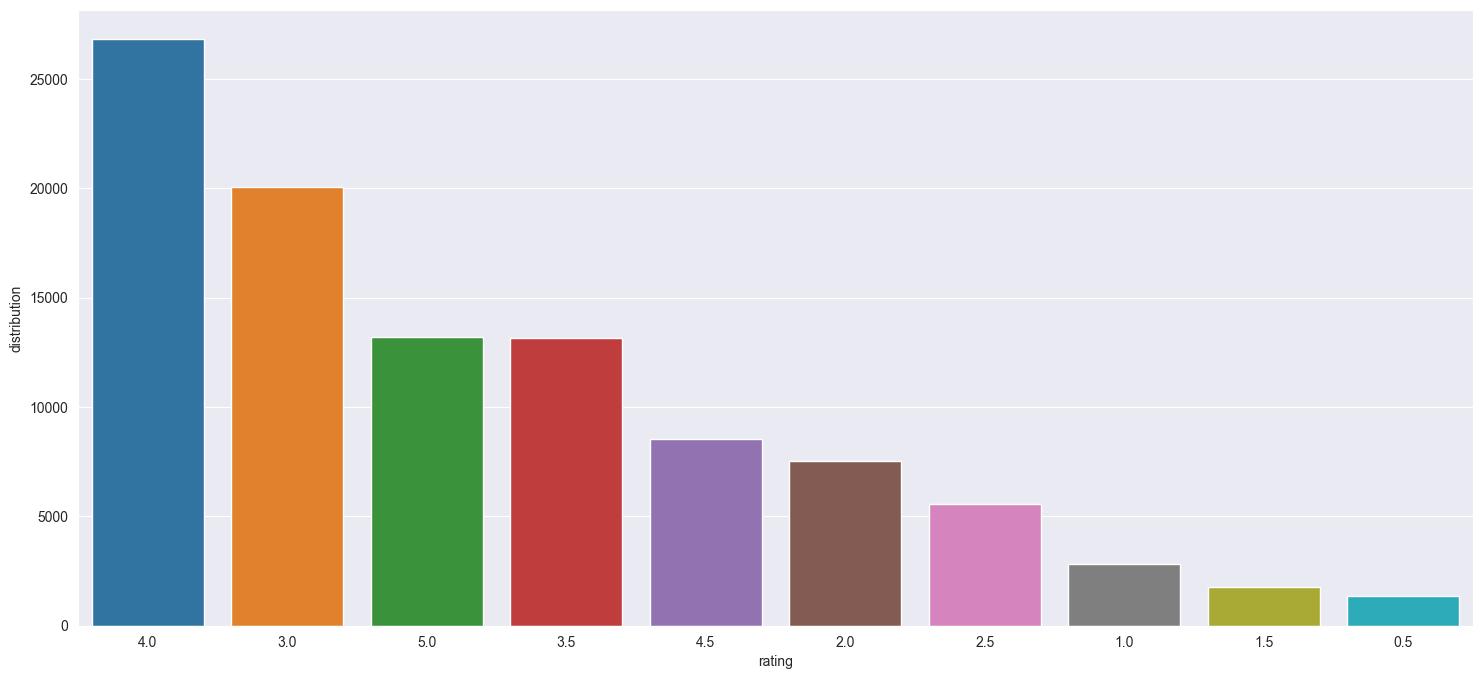

In [17]:
ratings_distr = ratings_df['rating'].value_counts().reset_index(name = 'distribution')
ratings_distr['rating'] = ratings_distr['rating'].astype(str)
display(Markdown('#### Distribution of Ratings in the Dataset'))

plt.figure(figsize = (18, 8))
sns.set_style('darkgrid')
sns.barplot(x = 'rating', y = 'distribution', data = ratings_distr)
plt.show()

### 1.5. Picking just a few sample of users, perhaps 20 or 30, is there any genre of movies they rate highly or lowly?

In [19]:
movies_df['genres']

0       Adventure|Animation|Children|Comedy|Fantasy
1                        Adventure|Children|Fantasy
2                                    Comedy|Romance
3                              Comedy|Drama|Romance
4                                            Comedy
                           ...                     
9737                Action|Animation|Comedy|Fantasy
9738                       Animation|Comedy|Fantasy
9739                                          Drama
9740                               Action|Animation
9741                                         Comedy
Name: genres, Length: 9742, dtype: object

In [20]:
movies_df['genres_split'] = movies_df['genres'].str.split('|')
movies_df

,movieId,title,genres,genres_split
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),Comedy,[Comedy]
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,"[Action, Animation, Comedy, Fantasy]"
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,"[Animation, Comedy, Fantasy]"
9739,193585,Flint (2017),Drama,[Drama]
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,"[Action, Animation]"


In [24]:
genres_df = movies_df.explode('genres_split')
genres_df

,movieId,title,genres,genres_split
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Animation
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Children
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Comedy
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Fantasy
...,...,...,...,...
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,Fantasy
9739,193585,Flint (2017),Drama,Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,Action
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,Animation


In [25]:
genres_df = genres_df.merge(ratings_df[['movieId', 'rating', 'userId']], on = 'movieId', how = 'inner')
genres_df

,movieId,title,genres,genres_split,rating,userId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure,4.0,1
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure,4.0,5
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure,4.5,7
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure,2.5,15
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure,4.5,17
...,...,...,...,...,...,...
274475,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,Fantasy,3.5,184
274476,193585,Flint (2017),Drama,Drama,3.5,184
274477,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,Action,3.5,184
274478,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,Animation,3.5,184


In [26]:
user_ratings_per_genre = genres_df.groupby(['userId', 'genres_split'])['rating'].agg(pd.Series.mode).to_frame().reset_index().explode('rating')

def fetch_genres_with_high_ratings(user_ratings_per_genre, userId):
    user_id_subset = user_ratings_per_genre['genres_split'].loc[
        (
            user_ratings_per_genre['userId'] == userId
        ) & (
            user_ratings_per_genre['rating'] >= 5.0
        )
    ]
    user_id_subset = list(np.unique(user_id_subset))
    if len(user_id_subset) == 0:
        return ['No Genre']
    else:
        return user_id_subset

def fetch_genres_with_low_ratings(user_ratings_per_genre, userId):
    user_id_subset = user_ratings_per_genre['genres_split'].loc[
        (
            user_ratings_per_genre['userId'] == userId
        ) & (
            user_ratings_per_genre['rating'] < 5.0
        )
    ]
    user_id_subset = list(np.unique(user_id_subset))
    if len(user_id_subset) == 0:
        return ['No Genre']
    else:
        return user_id_subset

user_ratings_per_genre['genres_with_high_ratings'] = user_ratings_per_genre['userId'].apply(
    lambda x: fetch_genres_with_high_ratings(user_ratings_per_genre, x)
)
user_ratings_per_genre['genres_with_low_ratings'] = user_ratings_per_genre['userId'].apply(
    lambda x: fetch_genres_with_low_ratings(user_ratings_per_genre, x)
)

In [27]:
user_ratings_per_genre

,userId,genres_split,rating,genres_with_high_ratings,genres_with_low_ratings
0,1,Action,5.0,"[Action, Adventure, Animation, Children, Comed...","[Horror, Romance, Western]"
1,1,Adventure,5.0,"[Action, Adventure, Animation, Children, Comed...","[Horror, Romance, Western]"
2,1,Animation,5.0,"[Action, Adventure, Animation, Children, Comed...","[Horror, Romance, Western]"
3,1,Children,5.0,"[Action, Adventure, Animation, Children, Comed...","[Horror, Romance, Western]"
4,1,Comedy,5.0,"[Action, Adventure, Animation, Children, Comed...","[Horror, Romance, Western]"
...,...,...,...,...,...
10023,610,Sci-Fi,3.5,[Film-Noir],"[Action, Adventure, Animation, Children, Comed..."
10024,610,Thriller,3.5,[Film-Noir],"[Action, Adventure, Animation, Children, Comed..."
10025,610,War,3.5,[Film-Noir],"[Action, Adventure, Animation, Children, Comed..."
10025,610,War,4.0,[Film-Noir],"[Action, Adventure, Animation, Children, Comed..."


In [28]:
def get_genres_rated_highly_but_not_lowly(genres_with_high_ratings, genres_with_low_ratings):
    rated_high_but_not_low = list(set(genres_with_high_ratings) - set(genres_with_low_ratings))
    return rated_high_but_not_low

def get_genres_rated_highly_and_lowly(genres_with_high_ratings, genres_with_low_ratings):
    rated_high_and_low = set(genres_with_high_ratings).intersection(genres_with_low_ratings)
    return rated_high_and_low

user_ratings_per_genre['genres_rated_high_not_low'] = [
    get_genres_rated_highly_but_not_lowly(user_ratings_per_genre['genres_with_high_ratings'].iloc[index], user_ratings_per_genre['genres_with_low_ratings'].iloc[index])\
    for index in range(len(user_ratings_per_genre))
]

user_ratings_per_genre['genres_rated_high_and_low'] = [
    get_genres_rated_highly_and_lowly(user_ratings_per_genre['genres_with_high_ratings'].iloc[index], user_ratings_per_genre['genres_with_low_ratings'].iloc[index])\
    for index in range(len(user_ratings_per_genre))
]

In [29]:
pd.set_option("max_colwidth", None)
pd.options.display.max_rows = 100
user_ratings_per_genre.drop_duplicates(subset = 'userId')[['userId', 'genres_with_high_ratings', 'genres_with_low_ratings', 'genres_rated_high_not_low', 'genres_rated_high_and_low']].head(100)

,userId,genres_with_high_ratings,genres_with_low_ratings,genres_rated_high_not_low,genres_rated_high_and_low
0,1,"[Action, Adventure, Animation, Children, Comedy, Crime, Drama, Fantasy, Film-Noir, Musical, Mystery, Sci-Fi, Thriller, War, Western]","[Horror, Romance, Western]","[Action, Musical, Fantasy, Sci-Fi, Thriller, Children, Film-Noir, Comedy, Drama, Mystery, Crime, Animation, War, Adventure]",{Western}
17,2,"[Adventure, Documentary, Sci-Fi]","[Action, Adventure, Comedy, Crime, Drama, Horror, IMAX, Mystery, Romance, Sci-Fi, Thriller, War, Western]",[Documentary],"{Sci-Fi, Adventure}"
31,3,"[Action, Fantasy, Horror, Mystery, Sci-Fi, Thriller]","[Adventure, Animation, Children, Comedy, Crime, Drama, Fantasy, Musical, Romance, War]","[Action, Sci-Fi, Horror, Thriller, Mystery]",{Fantasy}
46,4,"[Adventure, Animation, Crime, Documentary, Fantasy, Film-Noir, Musical, Romance, Thriller, War]","[Action, Animation, Children, Comedy, Documentary, Drama, Horror, IMAX, Musical, Mystery, Sci-Fi, Western]","[Fantasy, Thriller, Film-Noir, Romance, Crime, War, Adventure]","{Documentary, Musical, Animation}"
65,5,"[Animation, Fantasy, Musical, War, Western]","[Action, Adventure, Children, Comedy, Crime, Drama, Horror, IMAX, Mystery, Romance, Sci-Fi, Thriller, War, Western]","[Musical, Fantasy, Animation]","{Western, War}"
82,6,"[Animation, IMAX, Musical]","[Action, Adventure, Children, Comedy, Crime, Drama, Fantasy, Film-Noir, Horror, Mystery, Romance, Sci-Fi, Thriller, War, Western]","[Musical, IMAX, Animation]",{}
100,7,"[Horror, War]","[Action, Adventure, Animation, Children, Comedy, Crime, Drama, Fantasy, Film-Noir, IMAX, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western]",[Horror],{War}
118,8,"[Animation, Children, Crime, Horror, IMAX, Musical, Mystery, Western]","[Action, Adventure, Comedy, Crime, Drama, Fantasy, Horror, IMAX, Mystery, Romance, Sci-Fi, Thriller, War, Western]","[Musical, Animation, Children]","{Horror, Western, Mystery, IMAX, Crime}"
135,9,"[Adventure, Fantasy, Mystery]","[Action, Animation, Children, Comedy, Crime, Drama, Film-Noir, Horror, IMAX, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western]","[Fantasy, Adventure]",{Mystery}
153,10,"[Action, Crime]","[Adventure, Animation, Children, Comedy, Drama, Fantasy, Horror, IMAX, Musical, Mystery, Romance, Sci-Fi, Thriller, War]","[Action, Crime]",{}


## 2. Data Preparation

In [30]:
def clean_titles(title):
    title = title.split()
    del title[-1]
    title = ' '.join(title)
    title = title.lower()
    title = re.sub('[^a-z0-9]', ' ', title)
    title = ' '.join([
        word for word in title.split() if word not in stop_words
    ])
    return title

movies_df['clean_title'] = movies_df['title'].apply(lambda x: clean_titles(x))
movies_df

,movieId,title,genres,genres_split,clean_title
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",toy story
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",jumanji
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]",grumpier old men
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]",waiting exhale
4,5,Father of the Bride Part II (1995),Comedy,[Comedy],father bride part ii
...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,"[Action, Animation, Comedy, Fantasy]",black butler book atlantic
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,"[Animation, Comedy, Fantasy]",game life zero
9739,193585,Flint (2017),Drama,[Drama],flint
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,"[Action, Animation]",bungo stray dogs dead apple


In [85]:
prep_df = movies_df.merge(ratings_df, on = 'movieId', how = 'inner')
prep_df

,movieId,title,genres,genres_split,clean_title,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",toy story,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",toy story,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",toy story,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",toy story,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",toy story,17,4.5,1305696483
...,...,...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,"[Action, Animation, Comedy, Fantasy]",black butler book atlantic,184,4.0,1537109082
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,"[Animation, Comedy, Fantasy]",game life zero,184,3.5,1537109545
100833,193585,Flint (2017),Drama,[Drama],flint,184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,"[Action, Animation]",bungo stray dogs dead apple,184,3.5,1537110021


In [32]:
movie_titles_vocabulary = tf.keras.layers.StringLookup(mask_token = None)
movie_titles_vocabulary.adapt(prep_df['clean_title'].values)

movie_model = tf.keras.models.Sequential(
    [
        movie_titles_vocabulary,
        tf.keras.layers.Embedding(movie_titles_vocabulary.vocabulary_size(), 64)
    ]
)

user_id_vocabulary = tf.keras.layers.IntegerLookup(mask_token = None)
user_id_vocabulary.adapt(prep_df['userId'].values)

user_model = tf.keras.Sequential(
    [
    user_id_vocabulary,
    tf.keras.layers.Embedding(user_id_vocabulary.vocabulary_size(), 64)
    ]
)

X_movie_embs = movie_model(prep_df['clean_title']).numpy()
X_userId_embs = user_model(prep_df['userId']).numpy()

Metal device set to: Apple M1


2024-01-01 01:38:04.254960: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [42]:
def encode_movie_genres(genres):
    
    unique_genres = list(np.unique('|'.join(prep_df['genres'].unique().tolist()).split('|')))
    result = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    
    for genre, index in zip(unique_genres, range(len(result))):
        if genre in genres:
            result[index] = 1
        else:
            result[index] = 0
    return result

In [50]:
genres = movies_df['genres_split'].apply(lambda x: ' '.join(x))
movie_ids = movies_df['movieId']

genres_movie_id_dict = {
    key:value for key, value in zip(movie_ids, genres)
}

In [51]:
for key, value in genres_movie_id_dict.items():
    genres_movie_id_dict[key] = encode_movie_genres(value)

In [52]:
len(genres), len(movie_ids)

(9742, 9742)

In [55]:
X_genres_encoded = np.array(prep_df['movieId'].map(genres_movie_id_dict).tolist())
X_genres_encoded

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [65]:
prep_df['rating'] = prep_df['rating'].astype(str)
prep_df['rating']

0         4.0
1         4.0
2         4.5
3         2.5
4         4.5
         ... 
100831    4.0
100832    3.5
100833    3.5
100834    3.5
100835    4.0
Name: rating, Length: 100836, dtype: object

In [87]:
# from sklearn.preprocessing import OneHotEncoder

# one_hot_encoder = OneHotEncoder()

# y = one_hot_encoder.fit_transform(prep_df[['rating']]).toarray()
# y

y = prep_df['rating']
y

0         4.0
1         4.0
2         4.5
3         2.5
4         4.5
         ... 
100831    4.0
100832    3.5
100833    3.5
100834    3.5
100835    4.0
Name: rating, Length: 100836, dtype: float64

In [88]:
from sklearn.model_selection import train_test_split

X_movie_train, X_movie_test, X_user_train, X_user_test, X_genres_train, X_genres_test, y_train, y_test = train_test_split(
    X_movie_embs,
    X_userId_embs, 
    X_genres_encoded,
    y, 
    test_size = 0.2, 
    stratify = X_userId_embs
)

In [93]:
input_A = tf.keras.layers.Input(shape = (64,))
input_B = tf.keras.layers.Input(shape = (64,))
input_C = tf.keras.layers.Input(shape = (20,))
concat = tf.keras.layers.concatenate([input_A, input_B, input_C])
hidden = tf.keras.layers.Dense(64, activation = 'linear')(concat)
output = tf.keras.layers.Dense(1, activation = 'linear')(hidden)

rating_model = tf.keras.models.Model(inputs = [input_A, input_B, input_C], outputs = output)

rating_model.compile(
    optimizer = 'SGD',
    loss = 'mean_absolute_error'
)

history = rating_model.fit([X_user_train, X_movie_train, X_genres_train], y_train, epochs = 20, batch_size = 128, validation_split = 0.25)

Epoch 1/20
473/473 [==============================] - 7s 7ms/step - loss: 1.0395 - val_loss: 0.8353
Epoch 2/20
473/473 [==============================] - 2s 5ms/step - loss: 0.8205 - val_loss: 0.8127
Epoch 3/20
473/473 [==============================] - 2s 4ms/step - loss: 0.8065 - val_loss: 0.8068
Epoch 4/20
473/473 [==============================] - 2s 4ms/step - loss: 0.8028 - val_loss: 0.8050
Epoch 5/20
473/473 [==============================] - 2s 5ms/step - loss: 0.8006 - val_loss: 0.8029
Epoch 6/20
473/473 [==============================] - 2s 4ms/step - loss: 0.7993 - val_loss: 0.8020
Epoch 7/20
473/473 [==============================] - 2s 4ms/step - loss: 0.7984 - val_loss: 0.8007
Epoch 8/20
473/473 [==============================] - 2s 4ms/step - loss: 0.7973 - val_loss: 0.7998
Epoch 9/20
473/473 [==============================] - 2s 4ms/step - loss: 0.7964 - val_loss: 0.7989
Epoch 10/20
473/473 [==============================] - 2s 4ms/step - loss: 0.7955 - val_loss: 0.7982

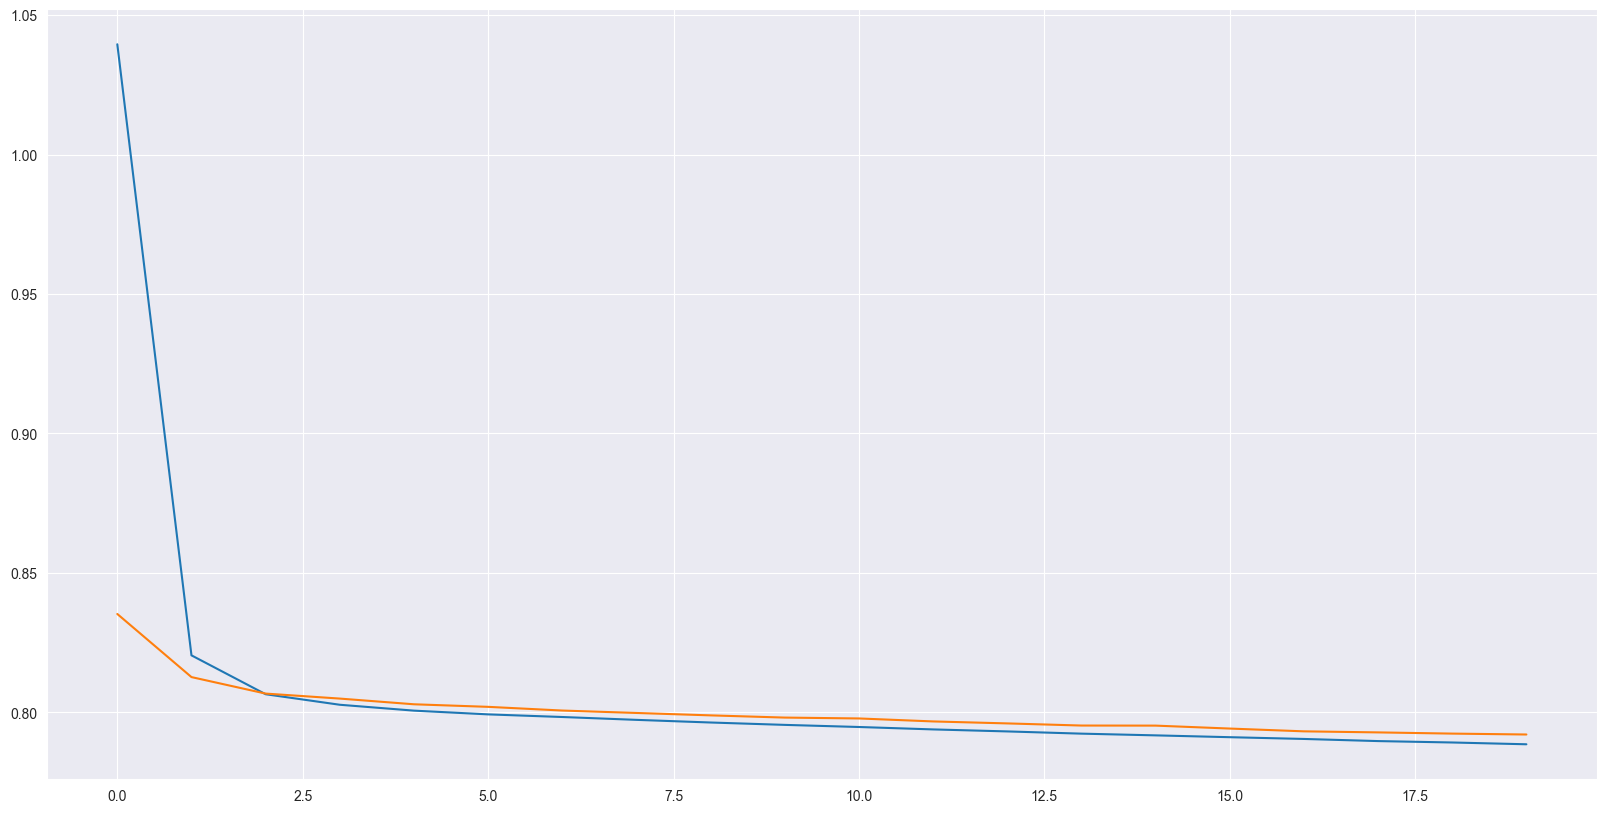

In [94]:
history_result= pd.DataFrame(history.history)

plt.figure(figsize = (20, 10))
plt.plot(history_result)
plt.show()

In [96]:
np.round(rating_model.predict([X_user_test, X_movie_test, X_genres_test]), 1)

631/631 [==============================] - 1s 2ms/step


array([[3.6],
       [3.9],
       [3.6],
       ...,
       [3.5],
       [3.7],
       [3.9]], dtype=float32)

In [97]:
y_test

29205    4.0
87133    4.5
56694    3.0
80006    2.0
1320     3.5
        ... 
53233    5.0
55458    4.0
94145    5.0
84461    4.5
96253    3.5
Name: rating, Length: 20168, dtype: float64

In [101]:
input_A = tf.keras.layers.Input(shape = (64,))
input_B = tf.keras.layers.Input(shape = (64,))
input_C = tf.keras.layers.Input(shape = (20,))
concat = tf.keras.layers.concatenate([input_A, input_B, input_C])
hidden = tf.keras.layers.Dense(64, activation = 'linear')(concat)
output = tf.keras.layers.Dense(1, activation = 'linear')(hidden)

rating_model = tf.keras.models.Model(inputs = [input_A, input_B, input_C], outputs = output)

rating_model.compile(
    optimizer = 'SGD',
    loss = 'mean_absolute_error'
)

history = rating_model.fit([X_user_train,
                            X_movie_train,
                            X_genres_train],
                           y_train, epochs = 20, 
                           batch_size = 128,
                           validation_data = ([X_user_test, X_movie_test, X_genres_test], y_test))

Epoch 1/20
631/631 [==============================] - 5s 6ms/step - loss: 0.9743 - val_loss: 0.8302
Epoch 2/20
631/631 [==============================] - 3s 4ms/step - loss: 0.8158 - val_loss: 0.8108
Epoch 3/20
631/631 [==============================] - 3s 4ms/step - loss: 0.8061 - val_loss: 0.8071
Epoch 4/20
631/631 [==============================] - 3s 4ms/step - loss: 0.8032 - val_loss: 0.8065
Epoch 5/20
631/631 [==============================] - 3s 4ms/step - loss: 0.8015 - val_loss: 0.8040
Epoch 6/20
631/631 [==============================] - 3s 4ms/step - loss: 0.8001 - val_loss: 0.8019
Epoch 7/20
631/631 [==============================] - 3s 4ms/step - loss: 0.7989 - val_loss: 0.8006
Epoch 8/20
631/631 [==============================] - 3s 4ms/step - loss: 0.7977 - val_loss: 0.7997
Epoch 9/20
631/631 [==============================] - 3s 4ms/step - loss: 0.7966 - val_loss: 0.7995
Epoch 10/20
631/631 [==============================] - 3s 4ms/step - loss: 0.7957 - val_loss: 0.7976

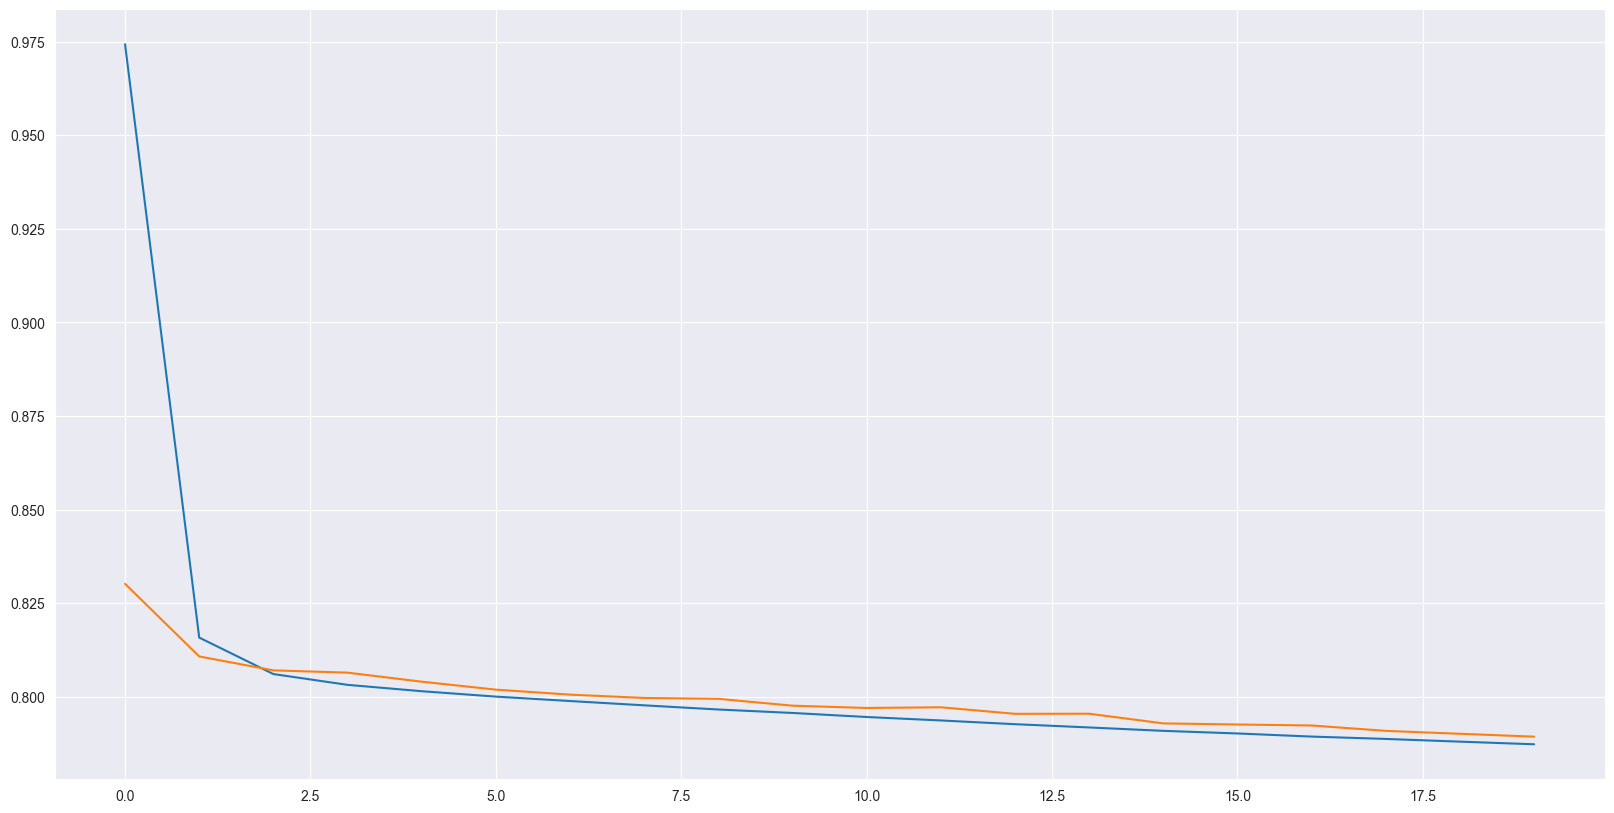

In [102]:
history_result= pd.DataFrame(history.history)

plt.figure(figsize = (20, 10))
plt.plot(history_result)
plt.show()

In [115]:
rating_model.layers

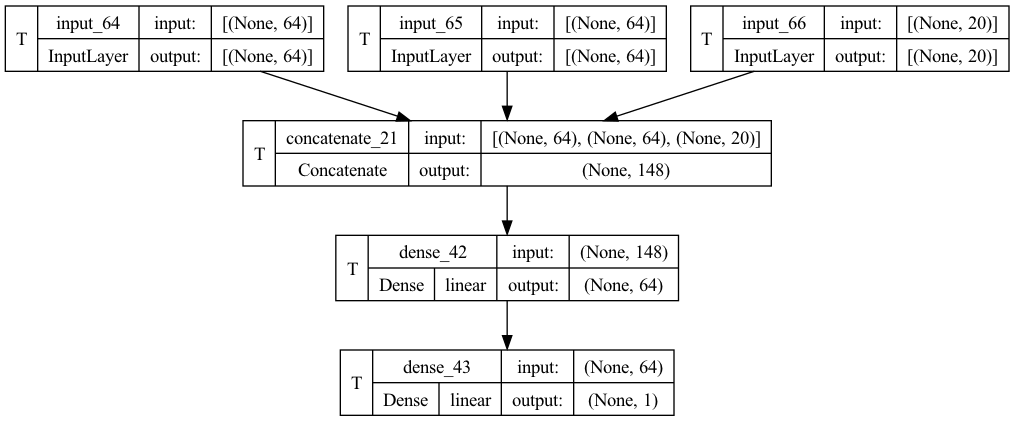

In [117]:
tf.keras.utils.plot_model(
    rating_model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=True
)

In [126]:
movies_df[['title', 'genres']].drop_duplicates()

,title,genres
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,Jumanji (1995),Adventure|Children|Fantasy
2,Grumpier Old Men (1995),Comedy|Romance
3,Waiting to Exhale (1995),Comedy|Drama|Romance
4,Father of the Bride Part II (1995),Comedy
...,...,...
9737,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,Flint (2017),Drama
9740,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [158]:
def clean_titles(title):
    title = title.split()
    del title[-1]
    title = ' '.join(title)
    title = title.lower()
    title = re.sub('[^a-z0-9]', ' ', title)
    title = ' '.join([
        word for word in title.split() if word not in stop_words
    ])
    return title

def create_rec_sys_dataset(userId):
    data = movies_df[['title', 'genres', 'movieId']].drop_duplicates()
    data['clean_title'] = data['title'].apply(clean_titles)
    data['userId'] = userId
    return data

def compute_embeddings(data):
    user_id_embeddings = user_model(data['userId']).numpy()
    movie_embeddings = movie_model(data['clean_title']).numpy()
    genre_embeddings = np.array(data['movieId'].map(genres_movie_id_dict).tolist())
    return user_id_embeddings, movie_embeddings, genre_embeddings

def predict_ratings(user_embeddings, movie_embeddings, genre_embeddings):
    prediction = np.round(rating_model.predict([user_embeddings, movie_embeddings, genre_embeddings]), 1)
    return prediction

def recommend(userId):
    data = create_rec_sys_dataset(userId)
    user_id_embeddings, movie_embeddings, genre_embeddings = compute_embeddings(data = data)
    prediction = predict_ratings(user_id_embeddings, movie_embeddings, genre_embeddings)
    data['predicted_rating'] = prediction
    return data['title'].loc[data['predicted_rating'] >= 4.5].tolist()

recommend(1)

305/305 [==============================] - 1s 2ms/step


['Patlabor: The Movie (Kidô keisatsu patorebâ: The Movie) (1989)',
 'Waltz with Bashir (Vals im Bashir) (2008)']

In [140]:
compute_embeddings(data = create_rec_sys_dataset(1))

AttributeError: 'Series' object has no attribute 'toarray'